In [43]:
#import pytrends
from __future__ import absolute_import, print_function, unicode_literals
import sys
import requests
import json
import re
import pandas as pd
from bs4 import BeautifulSoup
if sys.version_info[0] == 2:  # Python 2
    from urllib import quote
else:  # Python 3
    from urllib.parse import quote
    

class TrendReq(object):
    """
    Google Trends API
    """
    def __init__(self, username, password, custom_useragent=None):
        """
        Initialize hard-coded URLs, HTTP headers, and login parameters
        needed to connect to Google Trends, then connect.
        """
        self.username = username
        self.password = password
        # google rate limit
        self.google_rl = 'You have reached your quota limit. Please try again later.'
        self.url_login = "https://accounts.google.com/ServiceLogin"
        self.url_auth = "https://accounts.google.com/ServiceLoginAuth"
        # custom user agent so users know what "new account signin for Google" is
        if custom_useragent is None:
            self.custom_useragent = {'User-Agent': 'PyTrends'}
        else:
            self.custom_useragent = {'User-Agent': custom_useragent}
        self._connect()
        self.results = None

    def _connect(self):
        """
        Connect to Google.
        Go to login page GALX hidden input value and send it back to google + login and password.
        http://stackoverflow.com/questions/6754709/logging-in-to-google-using-python
        """
        self.ses = requests.session()
        login_html = self.ses.get(self.url_login, headers=self.custom_useragent)
        soup_login = BeautifulSoup(login_html.content, "lxml").find('form').find_all('input')
        dico = {}
        for u in soup_login:
            if u.has_attr('value'):
                try:
                    dico[u['name']] = u['value']
                except KeyError:
                    pass
        # override the inputs with out login and pwd:
        dico['Email'] = self.username
        dico['Passwd'] = self.password
        self.ses.post(self.url_auth, data=dico)

    def trend(self, payload, return_type=None):
        payload['cid'] = 'TIMESERIES_GRAPH_0'
        payload['export'] = 3
        req_url = "http://www.google.com/trends/fetchComponent"
        req = self.ses.get(req_url, params=payload)
        try:
            if self.google_rl in req.text:
                raise RateLimitError
            # strip off js function call 'google.visualization.Query.setResponse();
            text = req.text[62:-2]
            # replace series of commas ',,,,'
            text = re.sub(',+', ',', text)
            # replace js new Date(YYYY, M, 1) calls with ISO 8601 date as string
            pattern = re.compile(r'new Date\(\d{4},\d{1,2},\d{1,2}\)')
            for match in re.finditer(pattern, text):
                # slice off 'new Date(' and ')' and split by comma
                csv_date = match.group(0)[9:-1].split(',')
                year = csv_date[0]
                # js date function is 0 based... why...
                month = str(int(csv_date[1]) + 1).zfill(2)
                day = csv_date[2].zfill(2)
                # covert into "YYYY-MM-DD" including quotes
                str_dt = '"' + year + '-' + month + '-' + day + '"'
                text = text.replace(match.group(0), str_dt)
            self.results = json.loads(text)
        except ValueError:
            raise ResponseError(req.content)
        if return_type == 'json' or return_type is None:
            return self.results
        if return_type == 'dataframe':
            self._trend_dataframe()
            return self.results

    def related(self, payload, related_type):
        endpoint = related_type.upper() + '_QUERIES_0_0'
        payload['cid'] = endpoint
        payload['export'] = 3
        if 'hl' not in payload:
            payload['hl'] = 'en-US'
        req_url = "http://www.google.com/trends/fetchComponent"
        req = self.ses.get(req_url, params=payload)
        try:
            if self.google_rl in req.text:
                raise RateLimitError
            # strip off google.visualization.Query.setResponse();
            text = req.text[62:-2]
            self.results = json.loads(text)
        except ValueError:
            raise ResponseError(req.content)
        return self.results

    def top30in30(self):
        form = {'ajax': '1', 'pn': 'p1', 'htv': 'm'}
        req_url = "http://www.google.com/trends/hottrends/hotItems"
        req = self.ses.post(req_url, data=form)
        try:
            if self.google_rl in req.text:
                raise RateLimitError
            self.results = req.json()
        except ValueError:
            raise ResponseError(req.content)
        return self.results

    def hottrends(self, payload):
        req_url = "http://hawttrends.appspot.com/api/terms/"
        req = self.ses.get(req_url, params=payload)
        try:
            if self.google_rl in req.text:
                raise RateLimitError
            self.results = req.json()
        except ValueError:
            raise ResponseError(req.content)
        return self.results

    def hottrendsdetail(self, payload):
        req_url = "http://www.google.com/trends/hottrends/atom/feed"
        req = self.ses.get(req_url, params=payload)
        try:
            if self.google_rl in req.text:
                raise RateLimitError
            # returns XML rss feed!
            self.results = req.text
        except ValueError:
            raise ResponseError(req.content)
        return self.results

    def topcharts(self, payload):
        form = {'ajax': '1'}
        req_url = "http://www.google.com/trends/topcharts/category"
        req = self.ses.post(req_url, params=payload, data=form)
        try:
            if self.google_rl in req.text:
                raise RateLimitError
            self.results = req.json()
        except ValueError:
            raise ResponseError(req.content)
        return self.results

    def suggestions(self, keyword):
        kw_param = quote(keyword)
        req = self.ses.get("https://www.google.com/trends/api/autocomplete/" + kw_param)
        # response is invalid json but if you strip off ")]}'," from the front it is then valid
        try:
            if self.google_rl in req.text:
                raise RateLimitError
            self.results = json.loads(req.text[5:])
        except ValueError:
            raise ResponseError(req.content)
        return self.results

    def _trend_dataframe(self):
        # Only for trends
        df = pd.DataFrame()
        headers = []
        for col in self.results['table']['cols']:
            headers.append(col['label'])
        for row in self.results['table']['rows']:
            row_dict = {}
            for i, value in enumerate(row['c']):
                row_dict[headers[i]] = value['v']
            df = df.append(row_dict, ignore_index=True)
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
        self.results = df
        return self.results


class Error(Exception):
    """Base class for exceptions in this module."""
    pass


class RateLimitError(Error):
    """Exception raised for exceeding rate limit"""

    def __init__(self):
        self.message = "Exceeded Google's Rate Limit. Please use time.sleep() to space requests."
        print(self.message)


class ResponseError(Error):
    """Exception raised for exceeding rate limit"""

    def __init__(self, content):
        self.message = "Response did not parse. See server response for details."
        self.server_error = BeautifulSoup(content, "lxml").findAll("div", {"class": "errorSubTitle"})[0].get_text()
        print(self.message)
        print(self.server_error)


In [58]:

############
#portfolio optimization
############
import cvxopt
from cvxopt import solvers,sparse,printing
def mean_variance_model_optim(data,r=None,S=None,r0=0.01):
    """
        input paramater
        ----------------------
        data : ndarray
            (n*p) matrix
        r : ndarray
            mean vector
            (p*1) vector
        S : ndarray
            covariance matrix
            (p*p) matrix
        r0 : float
            lower bound of expected return.

        If r and S are None, then caluculate empirical mean
        and covariance matrix.
        ---------------------

        returns
        ---------------------
        sol : dictinary
            solution of quadratic programming.
        x : ndarray
            (p*1) vector
            the weight of portfolio
        ---------------------

    """
    N = data.shape[0]
    p = data.shape[1]

    if r == None:
        r = np.mean(data,0)
    if S == None:
        diff = data - r
        S = (1/float(N)) * np.dot(diff.T,diff)

    minus_r = np.matrix(-np.copy(r))

    P = cvxopt.matrix(np.copy(S))
    q = cvxopt.matrix(0.0,(p,1))
    I = cvxopt.matrix(0.0,(p,p))
    I[::p+1] = -1.0
    G = sparse([I])
    A = sparse([cvxopt.matrix(minus_r),cvxopt.matrix(1.0,(1,p))])
    b = cvxopt.matrix([-r0,1])
    h = cvxopt.matrix(np.zeros(p))
    sol = solvers.qp(P,q,G,h,A,b)
    x = sol['x']
    #print("ratio of portfolio : {}".format(x))
    print("portfolio return os {}".format(np.sum(cvxopt.mul(x,cvxopt.matrix(r)))))
    print("sum of ratio x is {}".format(np.sum(x)))
    return sol,x


def split_data(d,split_t):
    """
        input paramater
        ----------------------
        d : ndarray
         (n*p) matrix
        split_t : integer
            split data into training data and test data
            in index of split_t.
        ---------------------

        returns
        ---------------------
        d1 : ndarray
            traing data
        d2 : ndarray
            test data
        ---------------------

    """
    d1 = d[0:split_t,:]
    d2 = d[split_t:,:]
    print("d1.shape : ",d1.shape)
    print("d2.shape : ",d2.shape)
    return d1,d2

def window_data(d,start,window_size=100):
    """
        input paramater
        ----------------------
        d : ndarray
            (n*p) matrix
            (n*1) is acceptable
        start : integer
            index where window starts
        window_size : integer
            output window data contains in this number of data.
        ---------------------

        returns
        ---------------------
        window_d : ndarray
        ---------------------

    """
    if np.ndim(d) == 1:
        window_d = d[start:start+window_size]
    else:
        window_d = d[start:start+window_size,:]
    return window_d

def roling_portfolio(d,r0=0.01,window_size=100):
    """
        input paramater
        ----------------------
        d : ndarray
        r0 : float
            expecting return which the portfolio must satisfy.
        window_size : integer
            the range of window which caluculate ratio of portfolio.
        ---------------------

        returns
        ---------------------
        back_up_dict : dictionary
            test_retrun_emp_array ; return in test data for portfolio which used empirical covariance matrix.
        ---------------------

    """
    test_retrun_emp_array = []
    emp_true_variance_array = []
    sol_enp_output_array = []
    emp_status_array = []
    cvxopt.matrix_repr = printing.matrix_str_default #for dealing cvxopt matrix as np_matrix.
    for start in np.arange(len(d) - window_size -1):
        print("----------- step : {} -----------".format(start))
        d_window = window_data(d,start,window_size)
        N_window = d_window.shape[0]
        p_window = d_window.shape[1]
        sol_empirical,r1 = mean_variance_model_optim(d_window,r0=r0)
        sol_enp_output = sol_empirical['x']
        testdata = d[start+window_size+1,:] #predict only next term not all test data.

        test_retrun_emp = np.dot(testdata,sol_enp_output)[0]
        test_retrun_emp_array.append(test_retrun_emp)
        emp_status_array.append(sol_empirical['status'])
        sol_enp_output_list = [ np.array(sol_enp_output)[i][0] for i in np.arange(p_window)]
        sol_enp_output_array.append(np.array(sol_enp_output_list))

        #calculate true(base) variance.
        emp_true_variance = np.std(np.dot(d[start + window_size:,:],sol_enp_output))
        emp_true_variance_array.append(emp_true_variance)
        print("N,p : ",N_window,p_window)
        #print("Empirical Optimal Solution : {}".format(sol_empirical['status']))
        #print "S : ",S_window
        #print "sol_enp_output : ",np.array(sol_enp_output)
        #print "sol_lasso_output : ",np.array(sol_lasso_output)

    emp_diff = np.array(emp_true_variance_array) - np.array(test_retrun_emp_array)

    back_up_dict = {}
    back_up_dict['test_retrun_emp_array'] = test_retrun_emp_array
    back_up_dict['expected_return_emp'] = np.mean(test_retrun_emp_array)
    back_up_dict['risk_emp'] = np.std(test_retrun_emp_array) * 12
    back_up_dict['emp_true_variance_array'] = emp_true_variance_array
    back_up_dict['emp_diff'] = list(emp_diff)
    back_up_dict['mean_emp_diff'] = np.mean(emp_diff)
    back_up_dict['sol_enp_output_array'] = np.array(sol_enp_output_array)
    back_up_dict['emp_status_array'] = emp_status_array
    back_up_dict['window_size'] = window_size
    back_up_dict['r0'] = r0
    back_up_dict['p'] = d.shape[1]

    if 'unknown' in emp_status_array:
        print("!!!!!!!!Optimal solution was not found!!!!!!!!!")

    return back_up_dict

def logdiff(x):
    """
        input paramater
        ----------------------
        x : ndarray
            (n*1) vector
        ---------------------

        returns
        ---------------------
        x2 : ndarray
            (n-1)*1 vector
            taken log and one diff.
        ---------------------

    """
    x = np.log(x)
    x1 = list(np.r_[x,0])
    del x1[0]
    x1 = np.array(x1)
    x2 = list(x1 - x)
    N = len(x2)
    del x2[N-1]
    x2 = np.array(x2)
    return x2

def VAR_pred(GTNS_d1,d,i):
    """
        input paramater
        ----------------------
        GTNS_d1 : ndarray
            (n*1) vector
            d1 means one differenced.
        d : ndarray
            (n*p) array
        i : integer
            use variable index
        ---------------------
        returns
        ---------------------
        pred : float
            next value predicted by VAR model
            which contains GTNS_d1,and d[:,i] variable.
            (only two variables)
        ---------------------

    """
    X_var = np.c_[GTNS_d1,d[:,i]]
    model = VAR(X_var)
    #results = model.fit(maxlags=10, ic='aic')
    #model.select_order(5)
    lag_order = 4
    results = model.fit(lag_order)
    start_index = X_var.shape[0]-lag_order
    pred = results.forecast(X_var[start_index:,:], 1)[0][1]
    return pred

def roling_portfolio_VAR(d,GTNS_d1,r0=0.01,window_size=100):
    """
        input paramater
        ----------------------
        d : ndarray
            (n*p) matrix
        GTNS_d1 : ndarray
            (n*1) vector
        r0 : float
            expecting return which the portfolio must satisfy.
        window_size : integer
            the range of window which caluculate ratio of portfolio.
        ---------------------

        returns
        ---------------------
        back_up_dict : dictionary
            test_retrun_array ; return in test data for portfolio which used empirical covariance matrix.
        ---------------------

    """
    test_retrun_array = []
    true_variance_array = []
    sol_output_array = []
    status_array = []
    cvxopt.matrix_repr = printing.matrix_str_default #for dealing cvxopt matrix as np_matrix.
    for start in np.arange(len(d) - window_size -1):
        print("----------- step : {} -----------".format(start))
        d_window = window_data(d,start,window_size)
        N_window = d_window.shape[0]
        p_window = d_window.shape[1]
        GTNS_d1_window = window_data(GTNS_d1,start,window_size)

        r = np.array([ VAR_pred(GTNS_d1_window,d_window,i) for i in np.arange(p_window) ])

        sol,sol_output = mean_variance_model_optim(d_window,r=r,r0=r0)
        testdata = d[start+window_size+1,:] #predict only next term not all test data.

        test_retrun = np.dot(testdata,sol_output)[0]
        test_retrun_array.append(test_retrun)
        status_array.append(sol['status'])
        sol_output_list = [ np.array(sol_output)[i][0] for i in np.arange(p_window)]
        sol_output_array.append(np.array(sol_output_list))

        #calculate true(base) variance.
        true_variance = np.std(np.dot(d[start + window_size:,:],sol_output))
        true_variance_array.append(true_variance)
        print("N,p : ",N_window,p_window)
        #print("Optimal Solution : {}".format(sol['status']))

    diff = np.array(true_variance_array) - np.array(test_retrun_array)

    back_up_dict = {}
    back_up_dict['test_retrun_array'] = test_retrun_array
    back_up_dict['expected_return'] = np.mean(test_retrun_array)
    back_up_dict['risk'] = np.std(test_retrun_array) * 12
    back_up_dict['true_variance_array'] = true_variance_array
    back_up_dict['diff'] = list(diff)
    back_up_dict['mean_diff'] = np.mean(diff)
    back_up_dict['sol_output_array'] = np.array(sol_output_array)
    back_up_dict['status_array'] = status_array
    back_up_dict['window_size'] = window_size
    back_up_dict['r0'] = r0
    back_up_dict['p'] = d.shape[1]

    if 'unknown' in status_array:
        print("!!!!!!!!Optimal solution was not found!!!!!!!!!")

    return back_up_dict


In [4]:

google_username = "USERNAME"
google_password = "PASSWORD"

#load trend data
pytrend = TrendReq(google_username, google_password, custom_useragent='My Pytrends Script')
trend_payload1 = {'q': '倒産,債務,赤字,インフレ'}
trend_payload2 = {'q': '清算,貧困,不況,危機'}
trend1 = pytrend.trend(trend_payload1)
#print(trend1)
df1 = pytrend.trend(trend_payload1, return_type='dataframe')
#print(df1)
trend2 = pytrend.trend(trend_payload2)
#print(trend2)
df2 = pytrend.trend(trend_payload2, return_type='dataframe')
#print(df2)
df = pd.concat([df1,df2],axis=1)
df.head()

,インフレ,倒産,債務,赤字,不況,危機,清算,貧困
Date,,,,,,,,
2004-01-01,5.0,43.0,17.0,11.0,5.0,67.0,28.0,19.0
2004-02-01,4.0,38.0,24.0,12.0,6.0,55.0,30.0,6.0
2004-03-01,4.0,32.0,22.0,9.0,6.0,65.0,27.0,4.0
2004-04-01,3.0,36.0,12.0,7.0,1.0,100.0,26.0,9.0
2004-05-01,2.0,28.0,25.0,8.0,3.0,66.0,30.0,6.0


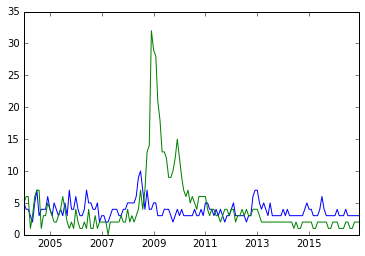

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(df['インフレ'],c="blue")
plt.plot(df['不況'],c="green")


explained_variance_ratio_ : [ 0.67257493]
0.672574929449


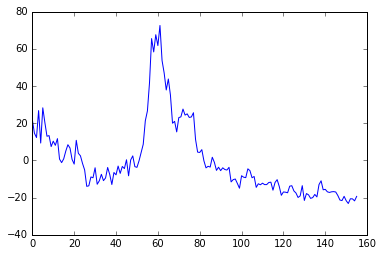

In [13]:
from sklearn.decomposition import PCA
import numpy as np

pca = PCA(n_components=1)
#when n=3 [ 0.64874278  0.21746775  0.07191107]
pca.fit(df)
print("explained_variance_ratio_ : {}".format(pca.explained_variance_ratio_))
#print(sum(pca.explained_variance_ratio_))
GTNS = pca.transform(df)
GTNS = np.array([ GTNS[i][0] for i in np.arange(len(GTNS)) ])
#GTNS = - GTNS
pca.score(df)
plt.plot(GTNS)


In [15]:
#loading return data
names = np.loadtxt("/Users/kazeto/Desktop/trend/from2000keys.csv",delimiter=",")
names30 = np.loadtxt("/Users/kazeto/Desktop/trend/30names.csv",delimiter=",",skiprows=1)
uppernames = names30[:,0]
lowernames = names30[:,1]
upper_bool = np.array(map(lambda x : x in uppernames, names))
lower_bool = np.array(map(lambda x : x in lowernames, names))
upper_index = names[upper_bool]
lower_index = names[lower_bool]
d = np.loadtxt("/Users/kazeto/Desktop/trend/logdiffdata.csv",delimiter=",")
d_upper = d[:,upper_bool]
d_lower = d[:,lower_bool]

#return is from 2000/2/29 ~ 2016/9/30
#google trends is from 2004-01-01 ~ 2016-12-01
GTNS = GTNS[0:len(GTNS)-2] #156 to 154
#GTNS = - GTNS[0:len(GTNS)-2] #156 to 154
d_upper = d_upper[45:len(d_upper)] #199 to 154
d_lower = d_lower[45:len(d_lower)] #199 to 154
upper_port = np.mean(d_upper,1)
lower_port = np.mean(d_lower,1)
X = np.c_[GTNS,upper_port,lower_port]


<Container object of 41 artists>

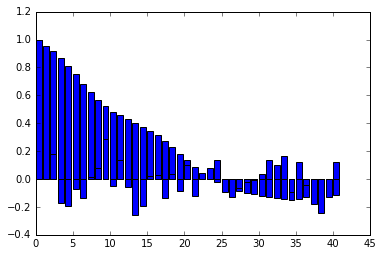

In [16]:
#VAR model
from statsmodels.tsa import stattools
from matplotlib import pyplot as plt
from statsmodels.tsa import arima_model
#auto correlation
GTNS_acf = stattools.acf(GTNS)
GTNS_pacf = stattools.pacf(GTNS)
plt.bar(np.arange(len(GTNS_acf)),GTNS_acf)

<Container object of 41 artists>

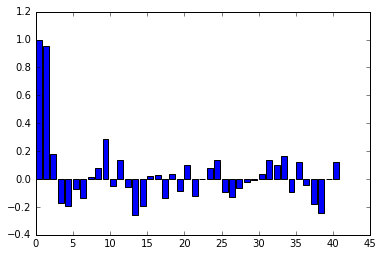

In [17]:
plt.bar(np.arange(len(GTNS_pacf)),GTNS_pacf)


In [18]:
ctt = stattools.adfuller(GTNS, regression="ctt")
ct = stattools.adfuller(GTNS, regression="ct")
c = stattools.adfuller(GTNS, regression="c")
nc = stattools.adfuller(GTNS, regression="nc")

In [23]:
#print p values
print("ctt : {}".format(ctt[1]))
print("ct : {}".format(ct[1]))
print("c : {}".format(c[1]))
print("nc : {}".format(nc[1]))
#we can not deny the hypothesis of not stationary.


ctt : 0.562066939855
ct : 0.500085970458
c : 0.390763024723
nc : 0.0683651460361


<Container object of 41 artists>

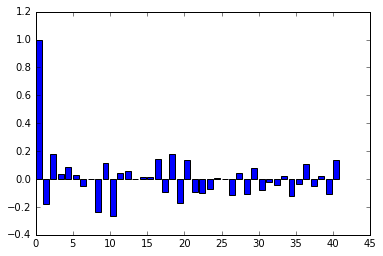

In [24]:
#taking difference
GTNS_d1 = np.array([ GTNS[i+1] - GTNS[i] for i in np.arange(len(GTNS)-1) ])
GTNS_d1_acf = stattools.acf(GTNS_d1)
GTNS_d1_pacf = stattools.pacf(GTNS_d1)
plt.bar(np.arange(len(GTNS_d1_acf)),GTNS_d1_acf)

<Container object of 41 artists>

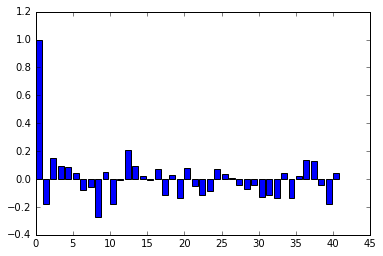

In [25]:
plt.bar(np.arange(len(GTNS_d1_pacf)),GTNS_d1_pacf)

In [26]:
ctt = stattools.adfuller(GTNS_d1, regression="ctt")
ct = stattools.adfuller(GTNS_d1, regression="ct")
c = stattools.adfuller(GTNS_d1, regression="c")
nc = stattools.adfuller(GTNS_d1, regression="nc")

In [27]:
#print p values
print("ctt : {}".format(ctt[1]))
print("ct : {}".format(ct[1]))
print("c : {}".format(c[1]))
print("nc : {}".format(nc[1]))


ctt : 0.201371997705
ct : 0.0771909888599
c : 0.0175904566666
nc : 0.0012542261609


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 16, Dec, 2016
Time:                     12:09:18
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -8.40610
Nobs:                     149.000    HQIC:                  -8.87292
Log likelihood:           89.5660    FPE:                0.000101949
AIC:                     -9.19237    Det(Omega_mle):     7.93228e-05
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const        -0.625514         0.474786           -1.317           0.190
L1.y1        -0.138631         0.083980           -1.651           0.101
L1.y2        42.511034        18.736672            2.269           0.025
L1.y3       -29.500698

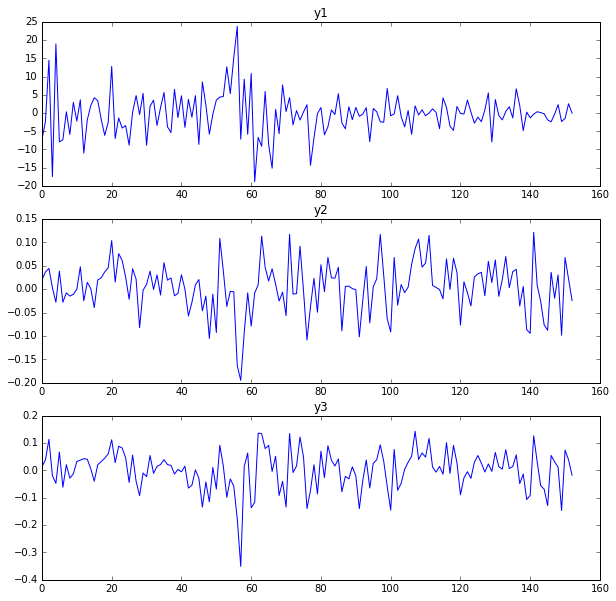

In [31]:
X = np.c_[GTNS_d1,upper_port[1:len(upper_port)],lower_port[1:len(lower_port)]]

from statsmodels.tsa.api import VAR
model = VAR(X)
lag_order = 4
results = model.fit(lag_order)
print(results.summary())
results.plot()


In [32]:
results.forecast(X[X.shape[0]-lag_order:,:], 5)
#results.plot_sample_acorr()


array([[ -1.73719190e+00,   6.77622780e-03,  -8.29398904e-03],
       [ -2.05811256e-01,   5.42578813e-03,   1.34075524e-02],
       [ -9.02755343e-01,   3.32727400e-03,  -7.01996040e-04],
       [ -1.85003650e-01,   6.54294111e-03,  -1.94931899e-04],
       [ -5.53171940e-01,   5.12323574e-03,   3.54391895e-03]])

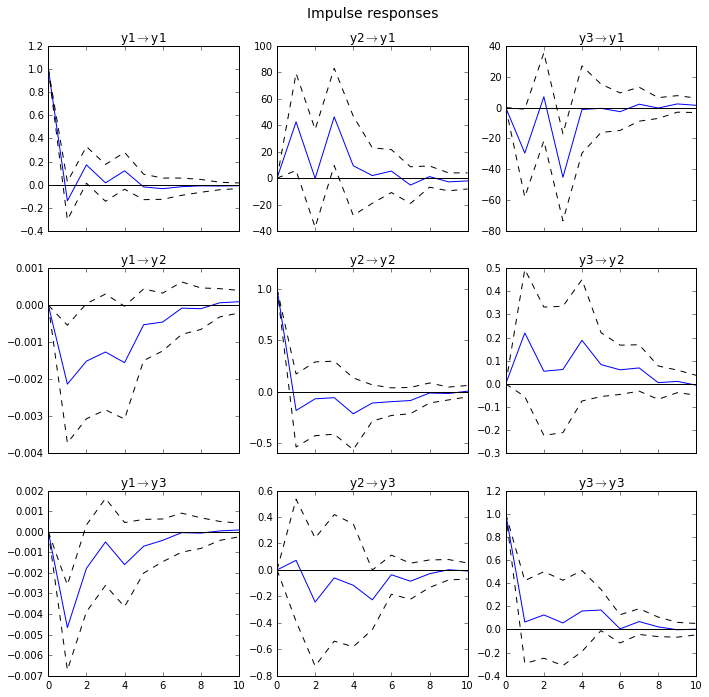

In [36]:
irf = results.irf(10)
irf.plot()
#y1 is GTNS
#y2 is upper portfolio
#y3 is lower port folio

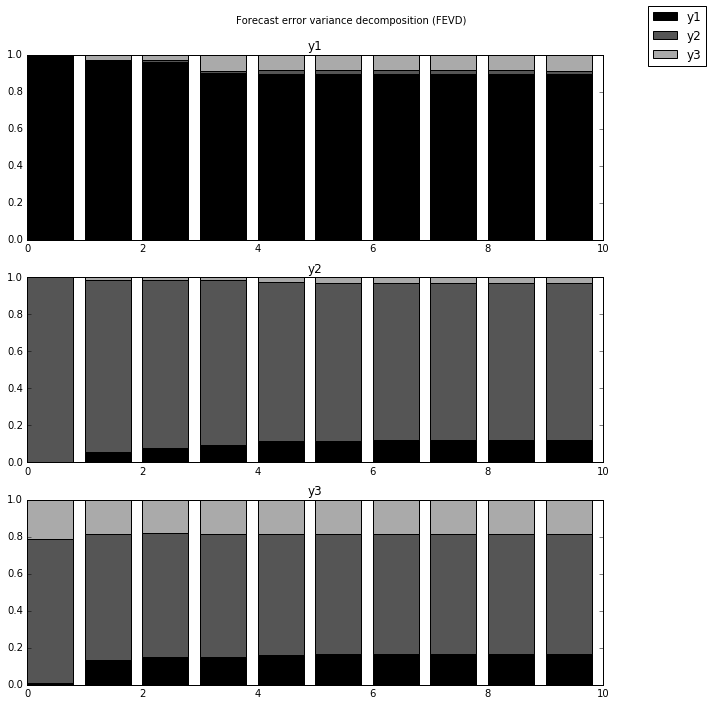

In [38]:
results.fevd().plot()


In [48]:
upper_m = np.mean(d_upper,0)
diff = d_upper - upper_m
upper_cov = (1/float(d_upper.shape[0])) * np.dot(diff.T,diff)
train_n = int(d_upper.shape[0] * 0.8)
traindata, testdata = split_data(d_upper,train_n)
sol_empirical,r1 = mean_variance_model_optim(traindata,r0=0.01)


d1.shape :  (123, 25)
d2.shape :  (31, 25)
     pcost       dcost       gap    pres   dres
 0:  1.6202e-03 -1.0273e+00  3e+01  5e+00  6e+00
 1:  1.6862e-03 -8.9234e-01  2e+00  2e-01  2e-01
 2:  1.8642e-03 -2.3810e-01  3e-01  1e-02  2e-02
 3:  1.8954e-03 -1.2082e-02  1e-02  5e-04  5e-04
 4:  1.7688e-03 -3.7433e-04  2e-03  6e-05  6e-05
 5:  1.6249e-03  1.2038e-03  4e-04  4e-06  5e-06
 6:  1.4202e-03  1.1562e-03  3e-04  1e-16  3e-18
 7:  1.3899e-03  1.3595e-03  3e-05  1e-16  3e-18
 8:  1.3827e-03  1.3753e-03  7e-06  1e-16  2e-18
 9:  1.3788e-03  1.3787e-03  1e-07  2e-16  3e-18
10:  1.3787e-03  1.3787e-03  1e-09  1e-16  2e-18
Optimal solution found.
ratio of portfolio : [ 2.08e-01]
[ 4.29e-08]
[ 8.26e-08]
[ 2.70e-01]
[ 3.71e-06]
[ 1.86e-08]
[ 1.43e-07]
[ 1.90e-08]
[ 8.91e-09]
[ 6.87e-08]
[ 1.68e-01]
[ 1.15e-08]
[ 4.25e-08]
[ 3.50e-08]
[ 7.95e-02]
[ 1.82e-08]
[ 5.15e-08]
[ 3.29e-08]
[ 3.58e-02]
[ 5.31e-07]
[ 9.08e-08]
[ 4.53e-06]
[ 3.96e-08]
[ 1.92e-01]
[ 4.54e-02]

portfolio return os 0.01

In [63]:
upper_output_dict = roling_portfolio(d_upper,window_size=130)
test_upper_return = np.array(upper_output_dict['test_retrun_emp_array'])

----------- step : 0 -----------
     pcost       dcost       gap    pres   dres
 0:  1.5530e-03 -1.0359e+00  3e+01  5e+00  6e+00
 1:  1.6088e-03 -9.0455e-01  2e+00  2e-01  2e-01
 2:  1.7448e-03 -2.6753e-01  3e-01  2e-02  2e-02
 3:  1.8163e-03 -1.3061e-02  1e-02  2e-15  5e-16
 4:  1.7169e-03 -2.4288e-04  2e-03  2e-15  8e-17
 5:  1.5136e-03  9.9615e-04  5e-04  2e-16  9e-18
 6:  1.3200e-03  1.0892e-03  2e-04  2e-16  2e-18
 7:  1.2738e-03  1.2258e-03  5e-05  3e-16  2e-18
 8:  1.2548e-03  1.2496e-03  5e-06  1e-16  2e-18
 9:  1.2515e-03  1.2514e-03  1e-07  7e-17  2e-18
10:  1.2514e-03  1.2514e-03  1e-09  2e-16  2e-18
Optimal solution found.
portfolio return os 0.01
sum of ratio x is 1.0
N,p :  130 25
----------- step : 1 -----------
     pcost       dcost       gap    pres   dres
 0:  1.5537e-03 -1.0354e+00  3e+01  5e+00  6e+00
 1:  1.6092e-03 -9.0640e-01  2e+00  1e-01  2e-01
 2:  1.7387e-03 -2.1563e-01  2e-01  1e-02  1e-02
 3:  1.7635e-03 -4.4550e-03  6e-03  2e-04  2e-04
 4:  1.6080e-03  3

In [64]:
GTNS_upper_output_dict = roling_portfolio_VAR(d_upper,GTNS_d1,window_size=130)
GTNS_upper_test_return = np.array(GTNS_upper_output_dict['test_retrun_array'])

----------- step : 0 -----------
     pcost       dcost       gap    pres   dres
 0:  1.6085e-03 -1.0391e+00  3e+01  5e+00  6e+00
 1:  1.6553e-03 -9.1658e-01  2e+00  2e-01  2e-01
 2:  1.7658e-03 -2.5663e-01  3e-01  2e-02  2e-02
 3:  1.7823e-03 -5.0454e-03  7e-03  3e-16  5e-16
 4:  1.6618e-03  3.4915e-04  1e-03  2e-16  9e-17
 5:  1.3551e-03  9.2455e-04  4e-04  1e-16  4e-18
 6:  1.2574e-03  1.1596e-03  1e-04  2e-16  2e-18
 7:  1.2228e-03  1.2050e-03  2e-05  7e-17  2e-18
 8:  1.2128e-03  1.2120e-03  7e-07  1e-16  2e-18
 9:  1.2123e-03  1.2123e-03  1e-08  8e-17  2e-18
Optimal solution found.
portfolio return os 0.01
sum of ratio x is 1.0
N,p :  130 25
----------- step : 1 -----------
     pcost       dcost       gap    pres   dres
 0:  1.4611e-03 -1.0163e+00  1e+00  6e-17  5e+00
 1:  1.4597e-03 -1.0250e-02  1e-02  4e-17  6e-02
 2:  1.3609e-03 -7.0736e-05  1e-03  4e-17  7e-03
 3:  9.8899e-04  3.9256e-04  6e-04  2e-16  2e-18
 4:  9.2496e-04  8.0270e-04  1e-04  3e-16  2e-18
 5:  8.9347e-04  8

/Users/kazeto/.pyenv/versions/anaconda-4.0.0/lib/python2.7/site-packages/ipykernel/__main__.py:39: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


     pcost       dcost       gap    pres   dres
 0:  1.4497e-03 -1.0200e+00  3e+01  5e+00  5e+00
 1:  1.4767e-03 -9.3150e-01  1e+00  3e-02  4e-02
 2:  1.4901e-03 -3.3258e-02  3e-02  4e-04  4e-04
 3:  1.4429e-03 -7.7259e-04  2e-03  3e-05  3e-05
 4:  1.1946e-03  7.2456e-04  5e-04  4e-06  4e-06
 5:  1.0060e-03  8.6291e-04  1e-04  1e-16  3e-18
 6:  9.6526e-04  9.5044e-04  1e-05  3e-16  3e-18
 7:  9.5606e-04  9.5443e-04  2e-06  1e-16  1e-18
 8:  9.5494e-04  9.5490e-04  5e-08  1e-16  2e-18
Optimal solution found.
portfolio return os 0.01
sum of ratio x is 1.0
N,p :  130 25
----------- step : 8 -----------
     pcost       dcost       gap    pres   dres
 0:  1.0482e-03 -1.0309e+00  3e+01  6e+00  6e+00
 1:  1.1482e-03 -7.8448e-01  3e+00  4e-01  5e-01
 2:  2.0865e-03 -2.5259e-01  1e+00  1e-01  2e-01
 3:  3.6136e-03 -1.5835e-01  2e-01  2e-15  2e-15
 4:  3.6014e-03 -4.6748e-04  4e-03  4e-15  5e-16
 5:  3.0840e-03  1.4117e-03  2e-03  1e-15  1e-16
 6:  2.2918e-03  1.6957e-03  6e-04  1e-16  2e-17
 7

In [89]:
print("empirical test mean : {}".format(np.mean(test_upper_return)))
print("GTNS test mean : {}".format(np.mean(GTNS_upper_test_return)))
print("empirical test std : {}".format(np.std(test_upper_return)))
print("GTNS test std : {}".format(np.std(GTNS_upper_test_return)))

print("diff of means : {}".format(np.abs(np.mean(test_upper_return) - np.mean(GTNS_upper_test_return))))


empirical test mean : -0.0040592000751
GTNS test mean : 0.00662104119874
empirical test std : 0.0511505226977
GTNS test std : 0.0521984265976
diff of means : 0.0106802412738


In [81]:
lower_output_dict = roling_portfolio(d_lower,window_size=120)
test_lower_return = np.array(lower_output_dict['test_retrun_emp_array'])

----------- step : 0 -----------
     pcost       dcost       gap    pres   dres
 0:  3.0715e-03 -1.0136e+00  3e+01  6e+00  6e+00
 1:  3.1126e-03 -7.5323e-01  4e+00  6e-01  6e-01
 2:  3.1357e-03 -1.3444e-01  1e+00  2e-01  2e-01
 3:  4.1249e-03 -1.1759e-01  1e-01  2e-15  2e-15
 4:  4.1216e-03  5.5661e-04  4e-03  7e-15  9e-16
 5:  3.8020e-03  1.9790e-03  2e-03  2e-15  3e-16
 6:  2.9889e-03  2.2291e-03  8e-04  1e-16  3e-17
 7:  2.7043e-03  2.6220e-03  8e-05  2e-16  2e-17
 8:  2.6377e-03  2.6341e-03  4e-06  1e-16  9e-18
 9:  2.6342e-03  2.6342e-03  4e-08  8e-17  1e-17
Optimal solution found.
portfolio return os 0.01
sum of ratio x is 1.0
N,p :  120 25
----------- step : 1 -----------
     pcost       dcost       gap    pres   dres
 0:  3.1094e-03 -1.0016e+00  3e+01  6e+00  6e+00
 1:  3.2263e-03 -7.3353e-01  4e+00  6e-01  6e-01
 2:  3.4598e-03 -4.0622e-02  1e+00  2e-01  2e-01
 3:  4.5215e-03 -5.0138e-02  1e-01  1e-02  1e-02
 4:  4.5449e-03 -1.3522e-02  2e-02  9e-05  9e-05
 5:  4.5443e-03  3

In [83]:
GTNS_lower_output_dict = roling_portfolio_VAR(d_lower,GTNS_d1,window_size=120)
GTNS_lower_test_return = np.array(GTNS_lower_output_dict['test_retrun_array'])

----------- step : 0 -----------
     pcost       dcost       gap    pres   dres
 0:  2.5029e-03 -1.0039e+00  3e+01  6e+00  6e+00
 1:  2.5894e-03 -7.4176e-01  3e+00  5e-01  5e-01
 2:  2.9122e-03 -6.4935e-02  9e-01  1e-01  1e-01
 3:  4.6041e-03 -7.6083e-02  1e-01  1e-02  1e-02
 4:  4.6395e-03 -1.1271e-02  2e-02  6e-05  7e-05
 5:  4.6351e-03  3.2811e-03  1e-03  5e-06  6e-06
 6:  3.9918e-03  2.8030e-03  1e-03  4e-16  4e-17
 7:  3.8842e-03  3.7575e-03  1e-04  2e-16  4e-17
 8:  3.7968e-03  3.7873e-03  9e-06  2e-16  3e-17
 9:  3.7886e-03  3.7882e-03  3e-07  2e-16  2e-17
10:  3.7882e-03  3.7882e-03  4e-09  2e-16  2e-17
Optimal solution found.
portfolio return os 0.01
sum of ratio x is 1.0
N,p :  120 25
----------- step : 1 -----------
     pcost       dcost       gap    pres   dres
 0:  2.9414e-03 -1.0408e+00  3e+01  5e+00  6e+00
 1:  3.0020e-03 -9.4030e-01  2e+00  2e-01  2e-01
 2:  3.0478e-03 -2.7959e-01  3e-01  2e-02  2e-02
 3:  3.0096e-03 -2.5057e-03  6e-03  8e-05  8e-05
 4:  2.6322e-03  6

/Users/kazeto/.pyenv/versions/anaconda-4.0.0/lib/python2.7/site-packages/ipykernel/__main__.py:39: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


     pcost       dcost       gap    pres   dres
 0:  2.7375e-03 -1.0136e+00  3e+01  5e+00  5e+00
 1:  2.7706e-03 -9.2407e-01  1e+00  7e-02  7e-02
 2:  2.7651e-03 -7.4413e-02  8e-02  9e-04  9e-04
 3:  2.6762e-03 -5.3830e-03  8e-03  9e-05  1e-04
 4:  1.9639e-03 -2.5329e-03  4e-03  2e-05  2e-05
 5:  1.8188e-03  9.2481e-04  9e-04  4e-06  4e-06
 6:  1.4940e-03  1.0545e-03  4e-04  7e-17  4e-18
 7:  1.4178e-03  1.3796e-03  4e-05  1e-16  3e-18
 8:  1.3955e-03  1.3933e-03  2e-06  2e-16  3e-18
 9:  1.3937e-03  1.3936e-03  5e-08  7e-17  4e-18
Optimal solution found.
portfolio return os 0.01
sum of ratio x is 1.0
N,p :  120 25
----------- step : 7 -----------
     pcost       dcost       gap    pres   dres
 0:  2.7646e-03 -1.0127e+00  1e+00  2e-16  5e+00
 1:  2.7614e-03 -1.0339e-02  1e-02  1e-16  7e-02
 2:  2.5570e-03 -1.1226e-04  3e-03  3e-17  1e-02
 3:  1.6697e-03 -6.2697e-05  2e-03  3e-16  5e-18
 4:  1.5589e-03  1.1295e-03  4e-04  1e-16  3e-18
 5:  1.4582e-03  1.3667e-03  9e-05  7e-17  4e-18
 6

In [88]:
print("empirical test mean : {}".format(np.mean(test_lower_return)))
print("GTNS test mean : {}".format(np.mean(GTNS_lower_test_return)))
print("empirical test std : {}".format(np.std(test_lower_return)))
print("GTNS test std : {}".format(np.std(GTNS_lower_test_return)))

print("diff of means : {}".format(np.abs(np.mean(test_lower_return) - np.mean(GTNS_lower_test_return))))

empirical test mean : -0.00386970747553
GTNS test mean : 0.0127092109908
empirical test std : 0.17896389896
GTNS test std : 0.0724438150326
diff of means : 0.0165789184663


#感想
・PCAをすると符号が固有ベクトルを求める時のアルゴリズムに依存してしまうので、GTNSが負の相関というのは恣意的かもしれないと思った。
・論文ではフランスのデータであったが、日本でもだいたい同じような結果になっている。